# Interpretable forecasting with N-Beats


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install lightning sktime pytorch-forecasting==1.0.0 cpflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Load data


We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.


In [4]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [5]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error


In [6]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(0.5462)

## Train network


In [7]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.004466835921509632
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.004466835921509632
INFO: Restoring states from the checkpoint path at /content/.lr_find_c50a12ff-94d4-43b2-aa55-07d204698621.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c50a12ff-94d4-43b2-aa55-07d204698621.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c50a12ff-94d4-43b2-aa55-07d204698621.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c50a12ff-94d4-43b2-aa55-07d204698621.ckpt


suggested learning rate: 0.004466835921509632


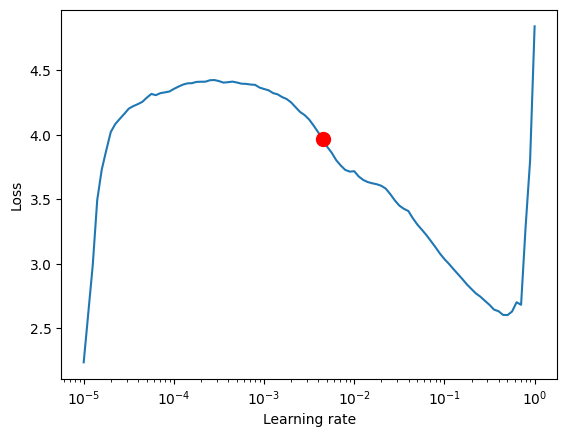

In [8]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model


In [9]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.7 M  | train
-------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type       | Params | Mode 
---------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### Evaluate Results


In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [11]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to("cpu")
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(0.1856)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!


In [12]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


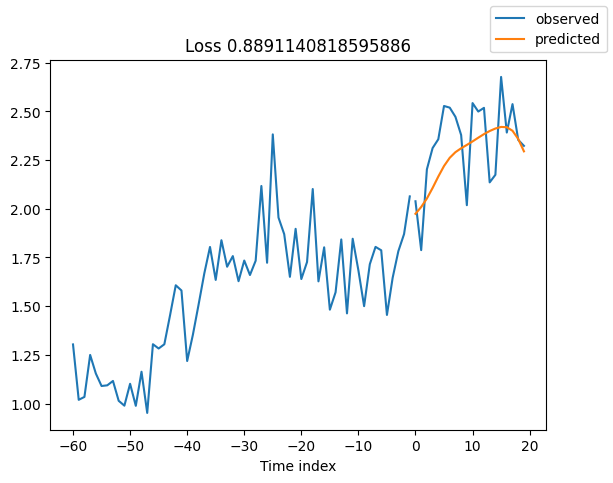

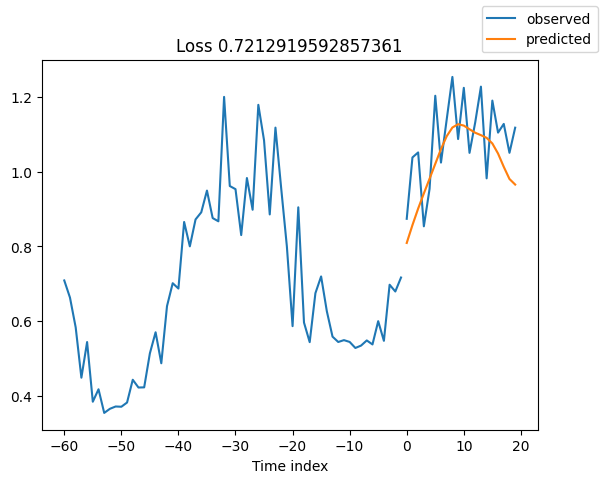

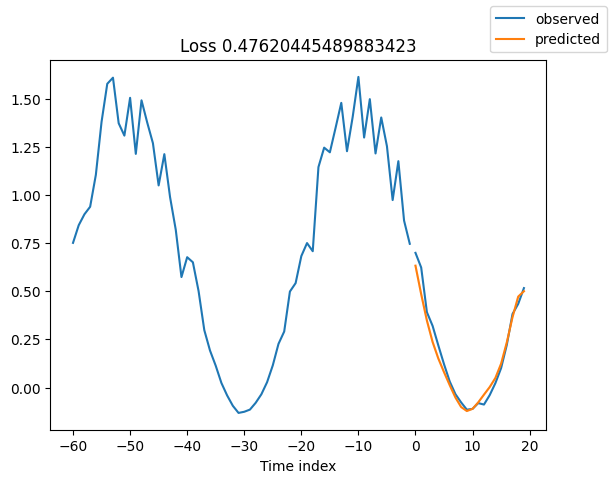

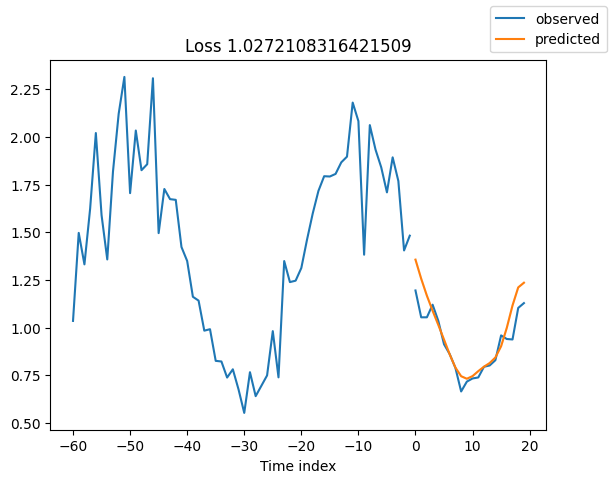

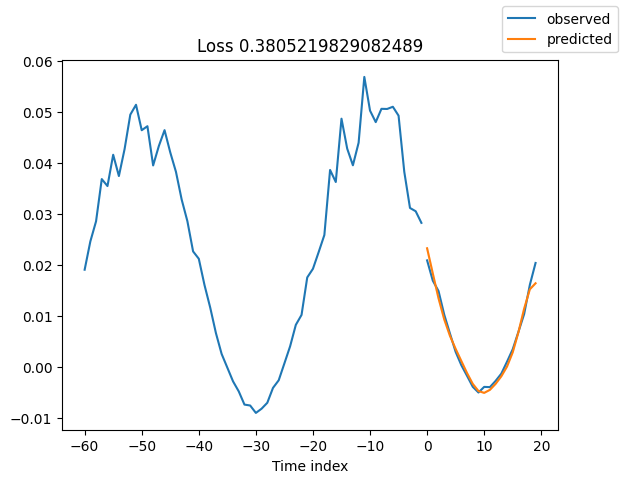

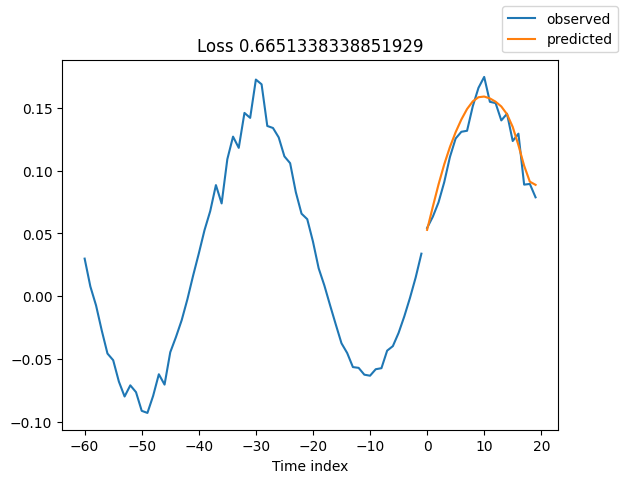

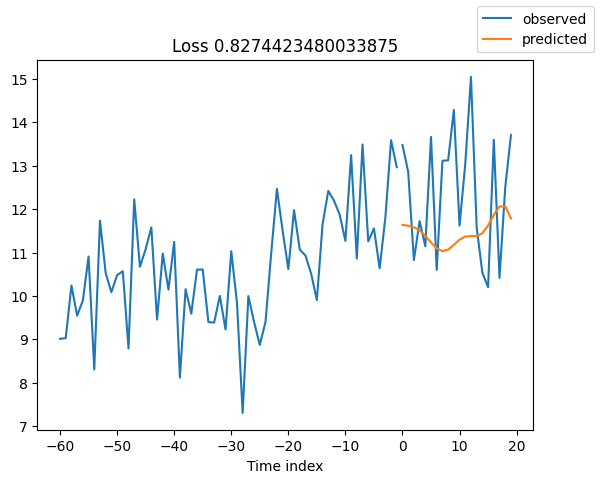

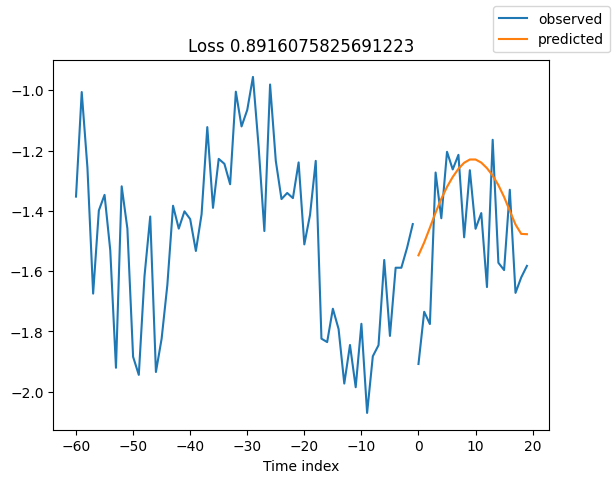

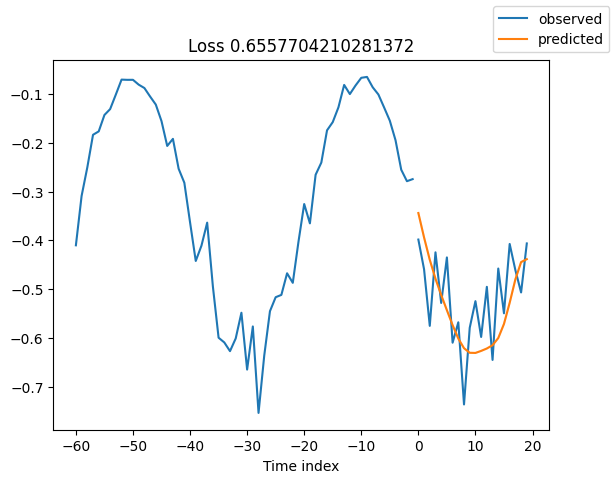

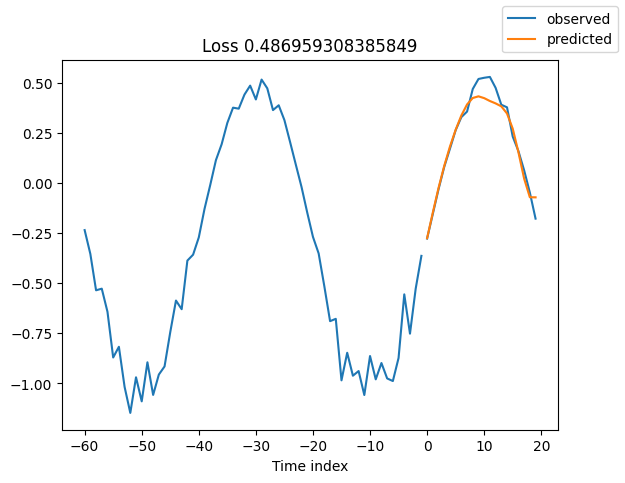

In [13]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

## Interpret model


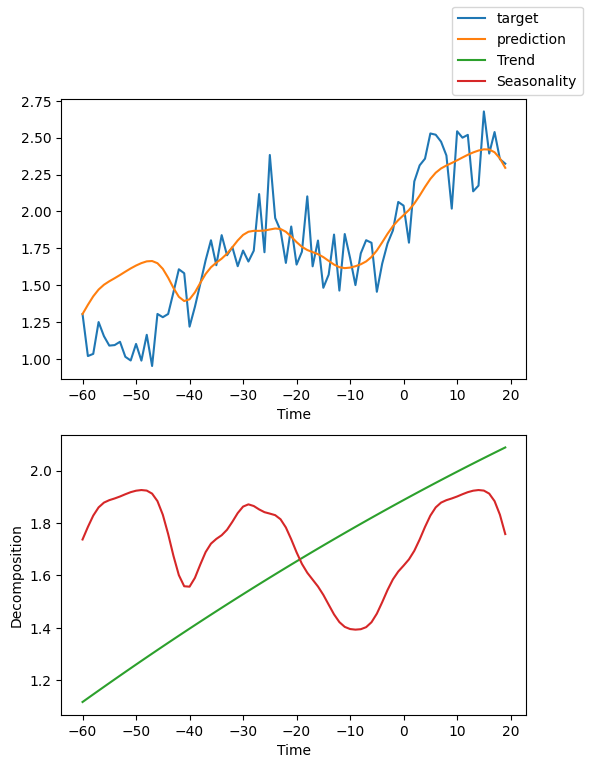

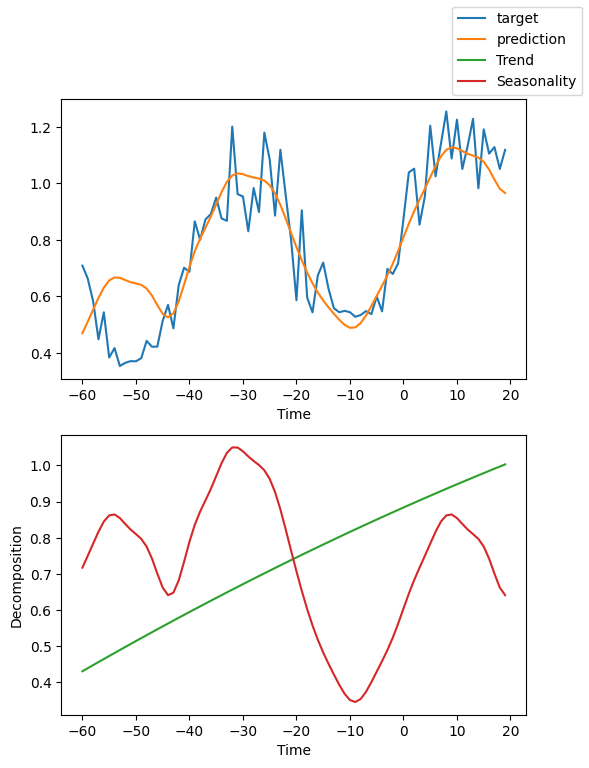

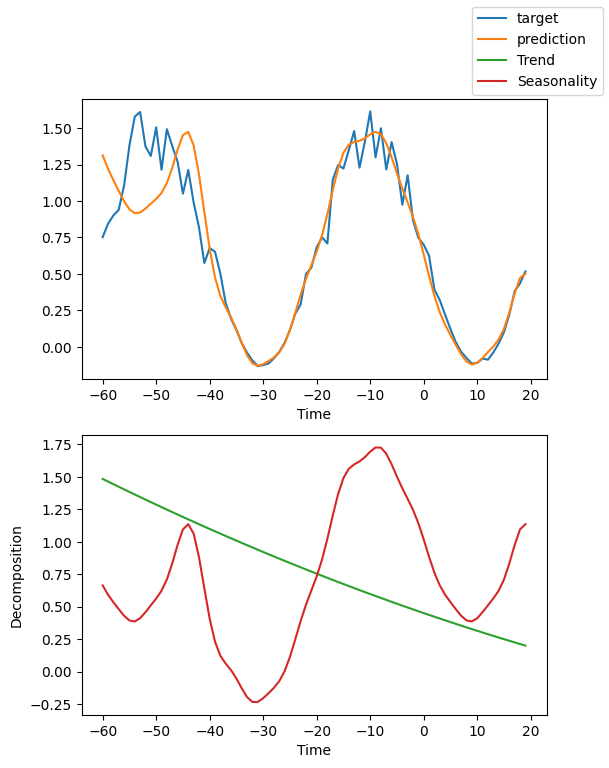

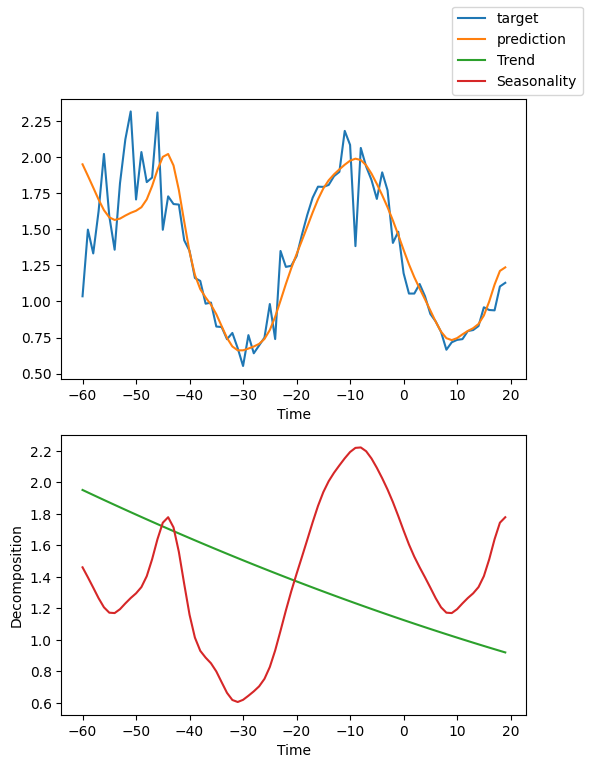

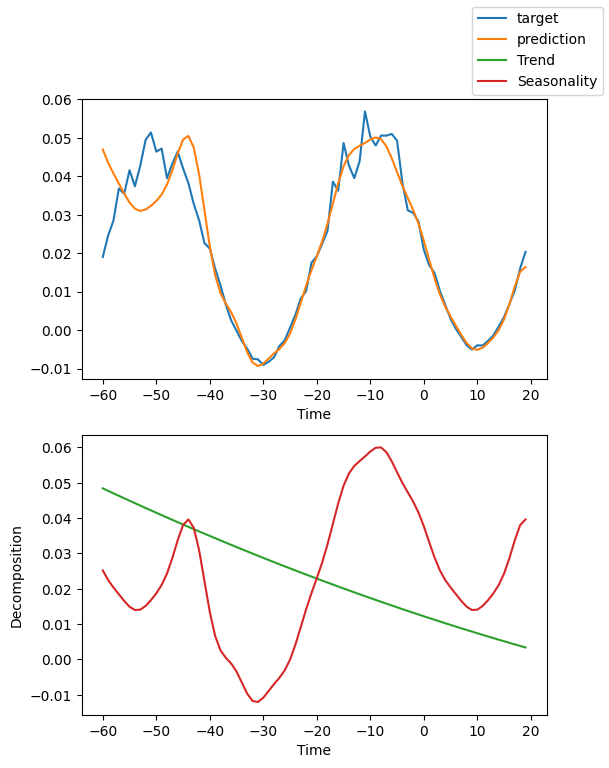

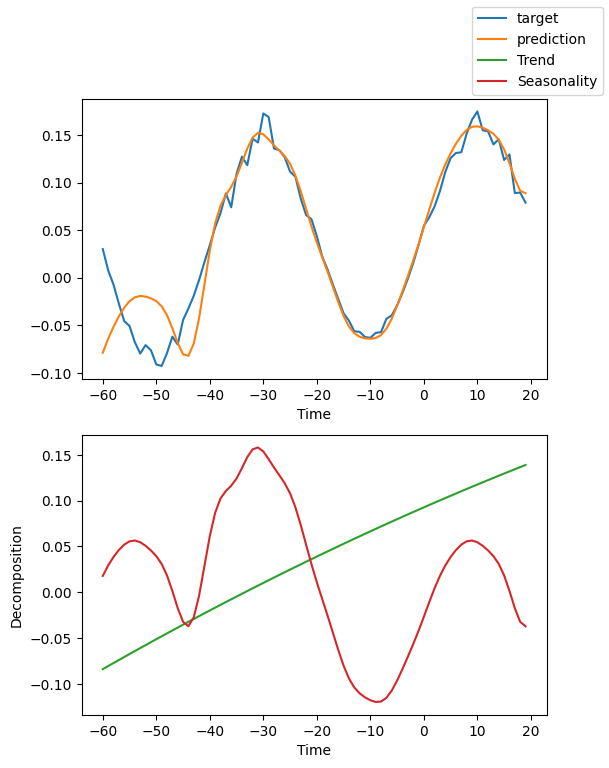

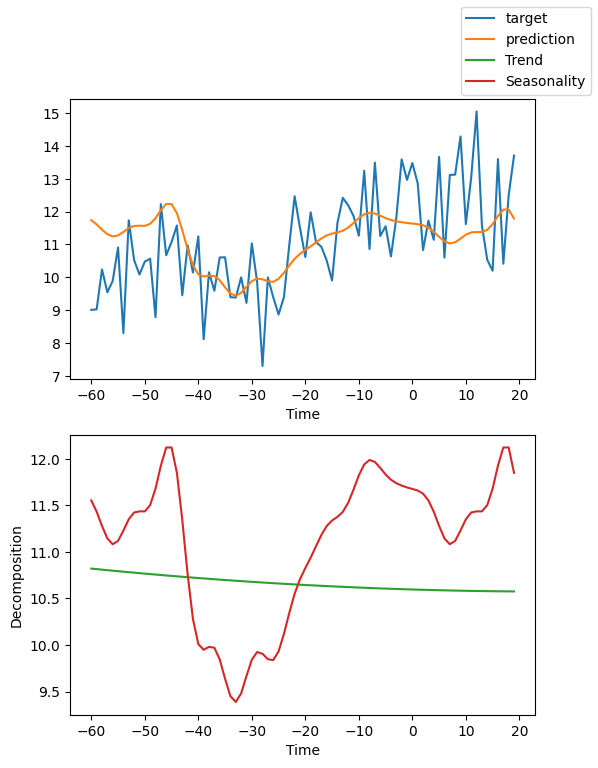

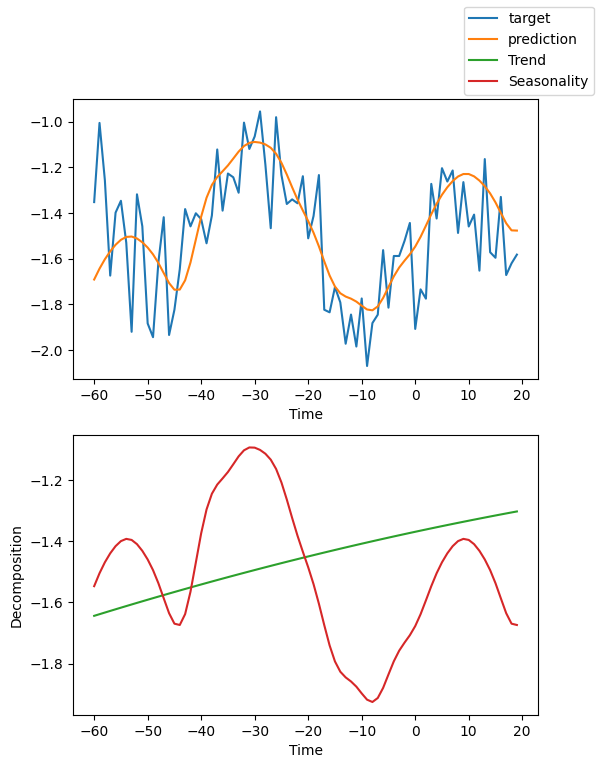

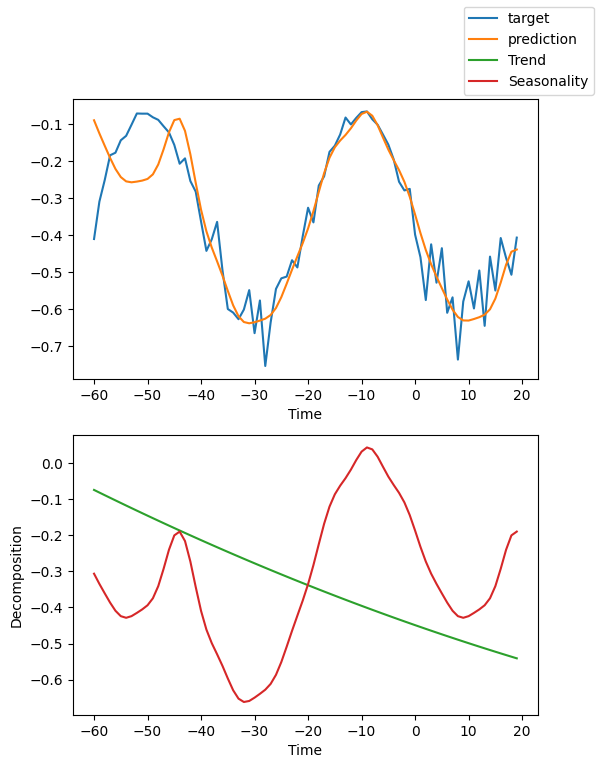

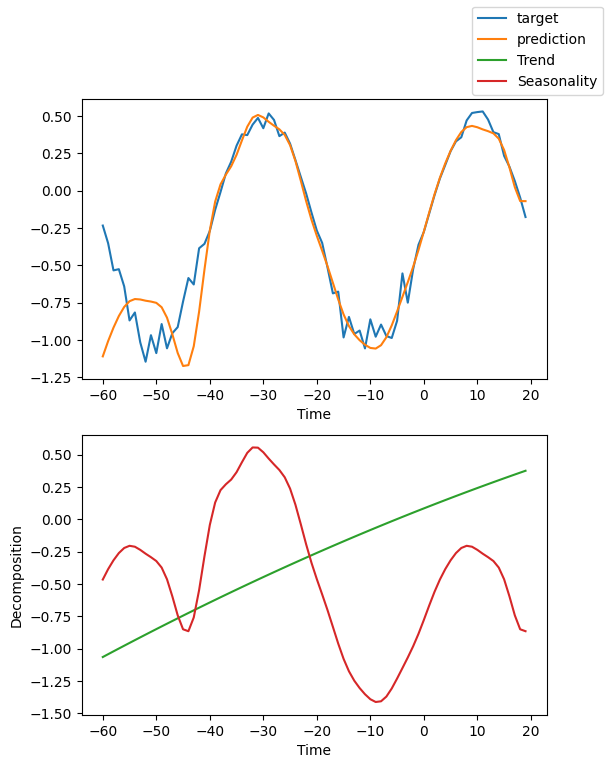

In [14]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

## Practice: Renewable Energy Forecasting
- Hourly dataset: Energy consumption in Romania
- Data Source: https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production

In [15]:
!pip install neuralforecast
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
import neuralforecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MAE

import os

import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv('/content/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'])
df.drop_duplicates(inplace=True)
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
46006,2024-03-31 19:00:00,5618,5902,1398,505,2294,1012,620,6,65
46007,2024-03-31 20:00:00,6107,6205,1395,671,2389,1037,645,0,66
46008,2024-03-31 21:00:00,5991,5855,1395,868,2201,705,621,0,66
46009,2024-03-31 22:00:00,5527,5726,1393,908,2088,648,622,0,66


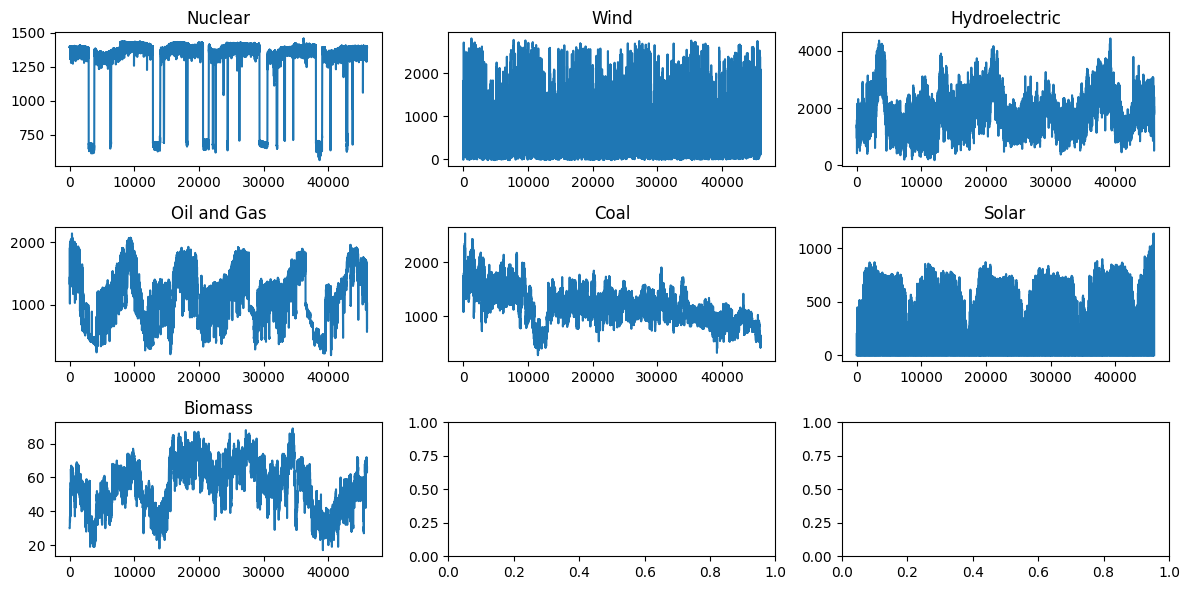

In [20]:
_, ax = plt.subplots(3, 3, tight_layout=True, figsize=(12,6))
for i, a in zip(np.arange(3, 10), ax.flat):
    a.plot(df.iloc[:, i])
    a.set_title(df.columns[i]);

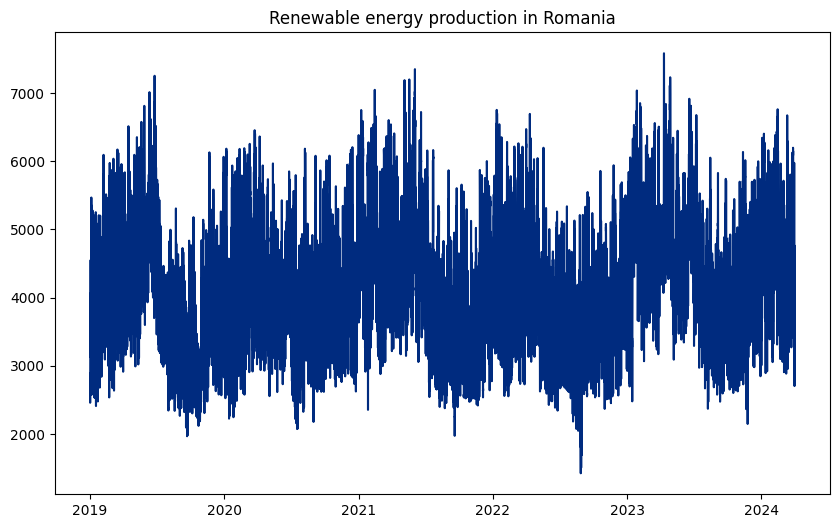

In [18]:
df['Renewable'] = df['Production'] - df['Coal'] - df['Oil and Gas']

plt.figure(figsize=(10, 6))
plt.plot(df.DateTime, df.Renewable, color='#002B7F')
plt.title('Renewable energy production in Romania');

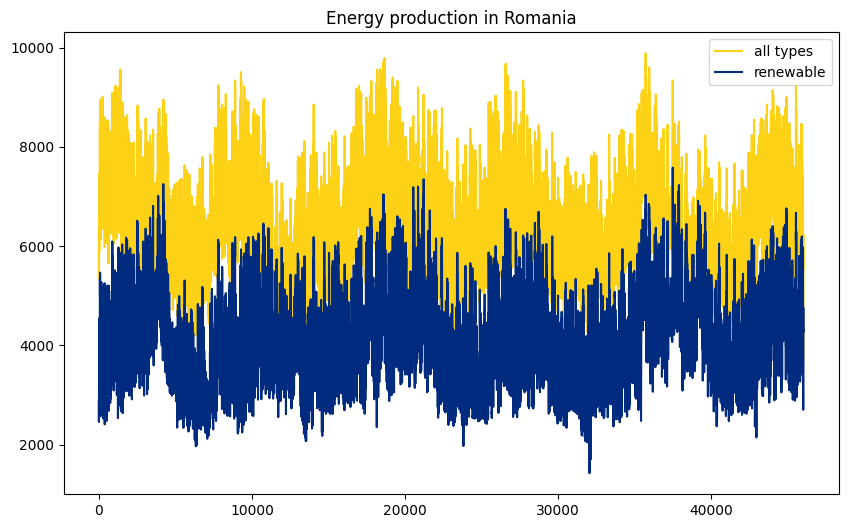

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df.Production, color='#FCD116', label='all types')
plt.plot(df.Renewable, color='#002B7F', label='renewable')
plt.legend()
plt.title('Energy production in Romania');

In [21]:
df['unique_id'] = df.DateTime.dt.year
df = df.loc[df.unique_id!=2024, ['DateTime', 'unique_id', 'Renewable']]
df['Renewable'] = df.Renewable.astype('float32')
df

,DateTime,unique_id,Renewable
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


In [22]:
df.rename({'Renewable': 'y', 'DateTime': 'ds'}, axis='columns', inplace=True)
df

,ds,unique_id,y
0,2019-01-01 00:00:00,2019,2887.0
1,2019-01-01 01:00:00,2019,2631.0
2,2019-01-01 02:00:00,2019,2595.0
3,2019-01-01 03:00:00,2019,2590.0
4,2019-01-01 04:00:00,2019,2542.0
...,...,...,...
43823,2023-12-31 19:00:00,2023,4753.0
43824,2023-12-31 20:00:00,2023,4776.0
43825,2023-12-31 21:00:00,2023,4909.0
43826,2023-12-31 22:00:00,2023,4187.0


In [24]:
OUR_HORIZON = 24*30*3

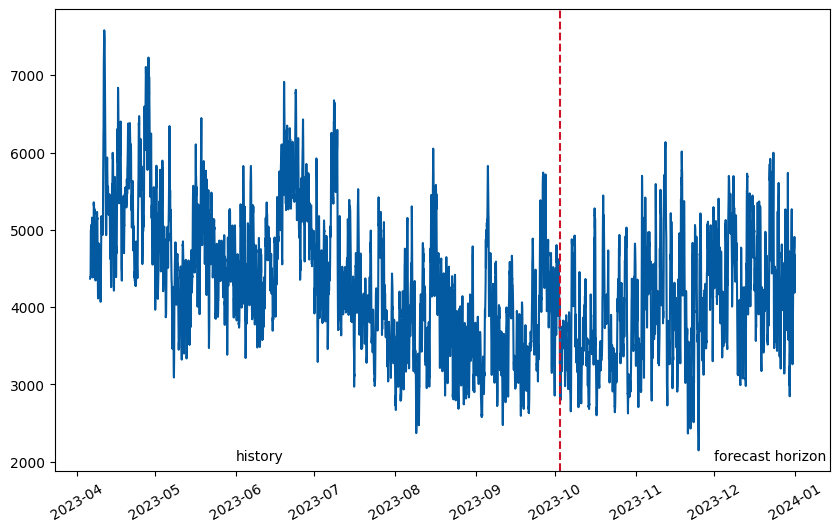

In [25]:
train = df.iloc[:-(3*OUR_HORIZON), :]
test = df.iloc[-(3*OUR_HORIZON):, :]

plt.figure(figsize=(10, 6))
plt.plot(test.ds, test.y, color='#045AA0')
plt.axvline(test.ds.iloc[-OUR_HORIZON], linestyle='--', color='#CE1126')
plt.text(x=pd.to_datetime('2023-06-01'), y=2024, s='history')
plt.text(x=pd.to_datetime('2023-12-01'), y=2024, s='forecast horizon')
plt.tick_params(axis='x', rotation=30);

In [29]:
nbeats = NBEATS(h=OUR_HORIZON, input_size=3*OUR_HORIZON, n_harmonics=2, n_polynomials=2,
                valid_loss=MAE(), max_steps=10, n_blocks=[2,2,1],
                batch_size=256, start_padding_enabled=True, num_workers_loader=3)
fcst = neuralforecast.NeuralForecast([nbeats], freq='h')

#max_steps 300

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [30]:
fcst.fit(train, val_size=OUR_HORIZON)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 71.2 M | train
-------------------------------------------------------
33.8 M    Trainable params
37.4 M    Non-trainable params
71.2 M    Total params
284.766   Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=10` reached.


In [31]:
electricity_forecast = fcst.predict(test)
electricity_forecast

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,NBEATS
unique_id,,
2023,2024-01-01 00:00:00,2887.069824
2023,2024-01-01 01:00:00,-972.791626
2023,2024-01-01 02:00:00,1820.023926
2023,2024-01-01 03:00:00,-4876.505859
2023,2024-01-01 04:00:00,6508.907227
...,...,...
2023,2024-03-30 19:00:00,-368.153076
2023,2024-03-30 20:00:00,-265.971191
2023,2024-03-30 21:00:00,9289.807617


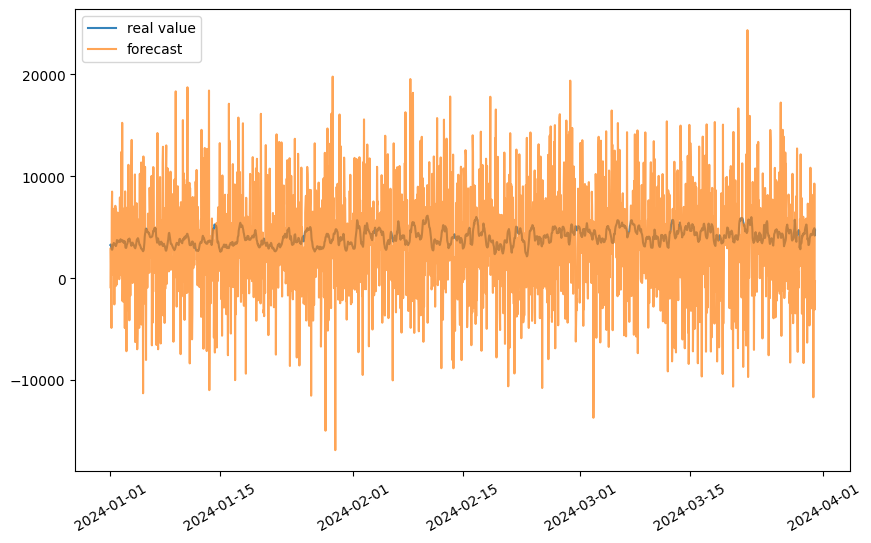

In [32]:
daterange = electricity_forecast.ds
plt.figure(figsize=(10, 6))
plt.plot(daterange, test.y.iloc[-OUR_HORIZON:], label='real value', alpha=0.9)
plt.plot(daterange, electricity_forecast.NBEATS, label='forecast', alpha=0.7)
plt.tick_params(axis='x', rotation=30)
plt.legend()
plt.show()

In [33]:
calculate_mae = MAE()
calculate_mae.__call__(y=torch.tensor(test.y.iloc[-OUR_HORIZON:].to_numpy()),
                       y_hat=torch.tensor(electricity_forecast.NBEATS.to_numpy()))

tensor(4175.0439)